In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyBigWig

In [69]:
'''
Created on May 3, 2016

@author: Gabe
'''
import pyBigWig
import numpy as np

class ReadDensity():
    """
    ReadDensity class
    Attributes:
        self.pos(positive *.bw file)
        self.neg(negative *.bw file)
    """
    def __init__(self, pos, neg, name = None):
        try:
            self.pos = pyBigWig.open(pos)
            self.neg = pyBigWig.open(neg)
            self.name = name if name is not None else pos.replace('pos','*').replace('neg','*')
        except Exception as e:
            print("couldn't open the bigwig files!")
            print(e)
            return 1
    def get_name(self):
        """
        returns name
        """
        return self.name
    
    def values(self, chrom, start, end, strand):
        """
        Given a chromosome coordinate, return a list of values
        pertaining to the rbpmaps over each nucleotide position.
        Reverse the list if going in the negative strand.
        
        Args:
            chrom (str): (eg. chr1)
            start (int): 0-based start (first position in chromosome is 0)
            end (int): 1-based end (last position is not included)
            strand (char): either '+' or '-'
        """
        try:
            if strand == "+":
                return self.pos.values(chrom, start, end)
            elif strand == "-":
                return list(reversed(self.neg.values(chrom, start, end)))
            else:
                raise("Strand neither + or -")
        except RuntimeError:
            # usually occurs when no chromosome exists in the bigwig file
            return [np.NaN]*abs(start-end)


In [70]:
'''
Created on Sep 21, 2016

@author: brian
'''
import pybedtools as bt

class Feature():
    '''
    classdocs
    '''


    def __init__(self, annotation, source):
        '''
        Constructor
        '''
        self.annotation = annotation.rstrip()
        self.source = source

    def get_bedtool(self):
        if(self.source == 'bed'):
            chrom, start, end, name, score, strand = self.annotation.split('\t')
        return bt.create_interval_from_list([chrom,
                                             start,
                                             end,
                                             name,
                                             score,
                                             strand])

"""        
annotation = 'chr3:53274267:53274364:-@chr3:53271813:53271836:-@chr3:53268999:53269190:-'
print(annotation)
F = SkippedExonFeature(annotation, 'miso')
up, se, down = F.get_bedtools()
print(up)
print(se)
print(down)
"""

"        \nannotation = 'chr3:53274267:53274364:-@chr3:53271813:53271836:-@chr3:53268999:53269190:-'\nprint(annotation)\nF = SkippedExonFeature(annotation, 'miso')\nup, se, down = F.get_bedtools()\nprint(up)\nprint(se)\nprint(down)\n"

In [71]:
import itertools

def some_range(rbp, interval, left_flank = 0, right_flank = 0):
    if interval.strand == "+":
        wiggle = rbp.values(interval.chrom, interval.start - left_flank, interval.end + right_flank, interval.strand)
    elif interval.strand == "-":
        wiggle = rbp.values(interval.chrom, interval.start - left_flank, interval.end + right_flank, interval.strand)
    else:
        print "Strand not correct", interval.strand
        raise()
    return wiggle   
def get_scale(wiggle):
    # type: (Series) -> Series
    '''
    Returns a wiggle of any N that is divisible by 100.
    
    '''
    if(len(wiggle)==100): # no need to do any calculating.
        return wiggle
    elif len(wiggle) == 1:
        return pd.Series(list(itertools.chain.from_iterable([multiply(w) for w in wiggle])))
    elif len(wiggle) < 100: 
        wiggle = pd.Series(list(itertools.chain.from_iterable([multiply(w) for w in wiggle])))
        
    dist = [0]*100
    x = 0
    step = 0.01
    y = 0
        
    for pos, value in enumerate(wiggle):
        if(float(pos+1)/len(wiggle)) < step:
            y = y + 1
            dist[x] = dist[x] + value            
        else:
            dist[x] = dist[x] / y
                
            step = step + 0.01
            x = x + 1
            dist[x] = value
            y = 1
    dist[x] = dist[x] / y
    return(pd.Series(dist))
def rename_index(interval_name):
    # type: (str) -> str
    '''
    Reformats a BedTool Interval name into a non-tabbed format.
    '''
    chrom, start, end, name, score, strand = str(interval_name).strip().split('\t')
    return "{}:{}-{}:{}:{}".format(chrom, start, end, name, strand)


In [72]:
'''
Created on Jun 18, 2016

@author: brianyee
'''
import pandas as pd
import numpy as np

def create_matrix(annotation, density, upstream_offset, downstream_offset, is_scaled = True, annotation_type = 'bed'):
    # print("creating the matrix for {}".format(density.get_name()))
    count = 0
    densities = {}
    with open(annotation) as f:
        for line in f:
            if not line.startswith('event_name') and not line.startswith('ID'):
                count = count + 1
                if count % 50000 == 0:
                    print('processed {} features'.format(count))
                event = line.rstrip() # .split('\t')[0]
                interval = Feature(event, annotation_type).get_bedtool()
                wiggle = pd.Series(some_range(density, interval, 0, 0))
                wiggle = wiggle.fillna(0) # convert all nans to 0
                wiggle = abs(wiggle) # convert all values to positive
                if(is_scaled == True):
                    wiggle = get_scale(wiggle)
                densities[rename_index(interval)] = wiggle
                """
                if not all(np.isnan(wiggle)):
                    wiggle = wiggle.fillna(0) # convert all nans to 0
                    wiggle = abs(wiggle) # convert all values to positive
                    if(is_scaled == True):
                        wiggle = intervals.get_scale(wiggle)
                    densities[intervals.rename_index(interval)] = wiggle
                """
    return pd.DataFrame(densities).T

In [73]:
annotation = '/home/bay001/projects/maps_20160420/permanent_data/all_txStart_k562.bed'
pos = '/projects/ps-yeolab3/encode/analysis/encode_v12/603_01_DDX59.merged.r2.norm.pos.bw'
neg = '/projects/ps-yeolab3/encode/analysis/encode_v12/603_01_DDX59.merged.r2.norm.neg.bw'
rbp = ReadDensity(neg,pos)

In [60]:
df = create_matrix(annotation,ewsr1,0,0)

processed 50000 features
processed 100000 features
processed 150000 features


In [79]:
# this looks right...
interval = bt.create_interval_from_list(['chr10','100004277','100004430','shouldbeblank','0','+'])
i = some_range(rbp,interval)
i

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.19198693335056305,
 0.19198693335056305,
 0.19198693335056305,
 0.19198693335056305,
 0.19198693335056305,
 0.19198693335056305,
 0.19198693335056305,
 0.19198693335056305,
 0.19198693335056305,
 0.19198693335056305,
 0.19198693335056305,
 0.19198693335056305,
 0.19198693335056305,
 0.19198693335056305,
 0.19198693335056305,
 0.19198693335056305,
 0.19198693335056305,
 0.19198693335056305,
 0.19198693335056305,
 0.19198693335056305,
 0.19198693335056305,
 0.19198693335056305,
 0.19198693335056305,
 0.19198693335056305,
 0.19198693335056305,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,


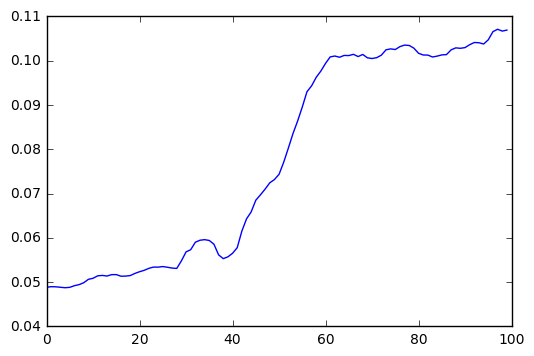

In [66]:
plt.plot(df.mean())

# We flip pos and neg bw already so this isn't the problem.

processed 50000 features
processed 100000 features
processed 150000 features


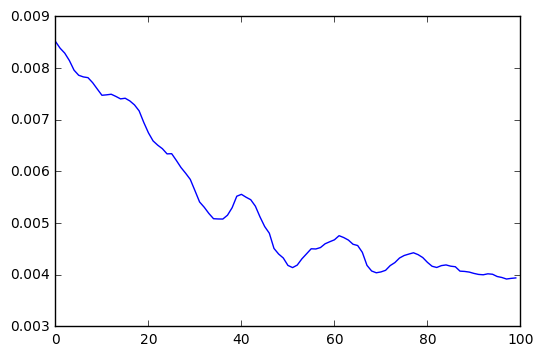

In [46]:
# unflipped
annotation = '/home/bay001/projects/maps_20160420/permanent_data/all_txStart_hepg2.bed'
pos = '/projects/ps-yeolab3/encode/analysis/encode_v12/203_02_HNRNPC.merged.r2.norm.pos.bw'
neg = '/projects/ps-yeolab3/encode/analysis/encode_v12/203_02_HNRNPC.merged.r2.norm.neg.bw'
rbp = ReadDensity(pos,neg)
df = create_matrix(annotation,rbp,0,0)
plt.plot(df.mean())

# Plotting the mean raw densities for 203_02 make more sense if we flip *.pos and *.neg

processed 50000 features
processed 100000 features
processed 150000 features


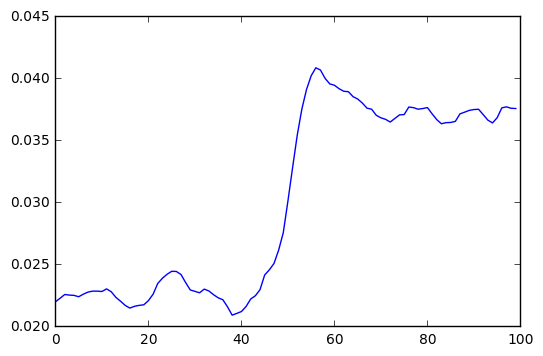

In [47]:
# flipped
annotation = '/home/bay001/projects/maps_20160420/permanent_data/all_txStart_hepg2.bed'
pos = '/projects/ps-yeolab3/encode/analysis/encode_v12/203_02_HNRNPC.merged.r2.norm.pos.bw'
neg = '/projects/ps-yeolab3/encode/analysis/encode_v12/203_02_HNRNPC.merged.r2.norm.neg.bw'
rbp = ReadDensity(neg,pos)
dx = create_matrix(annotation,rbp,0,0)
plt.plot(dx.mean())

# Input flipped.

processed 50000 features
processed 100000 features
processed 150000 features


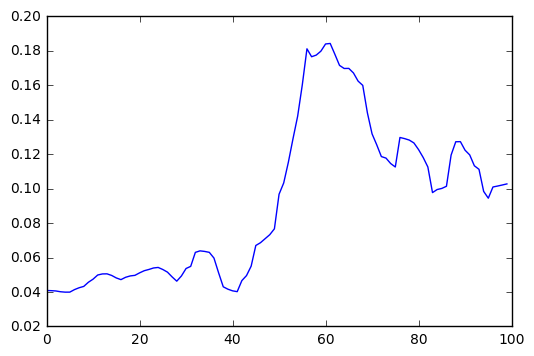

In [48]:
# input flipped
annotation = '/home/bay001/projects/maps_20160420/permanent_data/all_txStart_hepg2.bed'
pos = '/projects/ps-yeolab3/encode/analysis/encode_v12/271_INPUT_ATTACTCG-GGCTCTGA_L002_R1.unassigned.adapterTrim.round2.rmRep.rmDup.sorted.r2.norm.pos.bw'
neg = '/projects/ps-yeolab3/encode/analysis/encode_v12/271_INPUT_ATTACTCG-GGCTCTGA_L002_R1.unassigned.adapterTrim.round2.rmRep.rmDup.sorted.r2.norm.neg.bw'
rbp = ReadDensity(neg,pos)
dxi = create_matrix(annotation,rbp,0,0)
plt.plot(dxi.mean())

In [49]:
def normalize_and_per_region_subtract(density, input_density, min_density_threshold = 0):
    """
    Normalizes ip matrix of m x n (where m is the row of each event in a feature,
    and n is the column relating to nucleotide position). 
    """
    # PDF_CONST = 1.0/len(density.columns)
    
    dft = pd.merge(density,input_density, how='outer',left_index=True,right_index=True)
    
    dfx = dft.filter(regex='\d+_x')
    dfy = dft.filter(regex='\d+_y')
    
    pdf = calculate_pdf(dfx, min_density_threshold)
    pdfi = calculate_pdf(dfy, min_density_threshold)
    
    pdf = pdf.rename(columns=lambda x: x.replace('_x', ''))
    pdfi = pdfi.rename(columns=lambda x: x.replace('_y', ''))
    
    # pdfi = fill_all_nans_with_minpdf(pdfi, PDF_CONST)
    # pdf = fill_all_nans_with_minpdf(pdf, PDF_CONST)
    
    subtracted = pdf.sub(pdfi)
    # print("TYPE AFTER PER REGION SUBTRACT: {}".format(type(subtracted)))
    return subtracted

def calculate_pdf(density, min_density_threshold = 0):
    """
    Calculates the PDF of a density matrix.
    Logic:
    
    Args: 
        density (pandas.DataFrame) : r x c matrix of densities. May contain
            NaN corresponding to values in which no density was returned.
            These values should be counted.
            May contain -1 corresponding to values in which a particular
            region is shorter than the full DataFrame length. These 
            values should not be counted.
        min_density_threshold (integer) : minimum total density across
            a row. (Deprecated - may be removed in the future)
    
    Returns:
        pdf (pandas.DataFrame) : r x c matrix of densities normalized
            across each respective (r)ow as a probability density func.
    """
    density = density.fillna(0) # NaNs are regions which contain zero density
    df = density.replace(-1, np.nan) # -1 are regions which should not be counted at all
    
    # df = df[df.sum(axis=1) > min_density_threshold]
    min_normalized_read_number = min([item for item in df.unstack().values if item > 0])
    df = df + min_normalized_read_number
    pdf = df.div(df.sum(axis=1), axis=0)
    return pdf # , mean, sem

# PDF of raw density - looks correct?

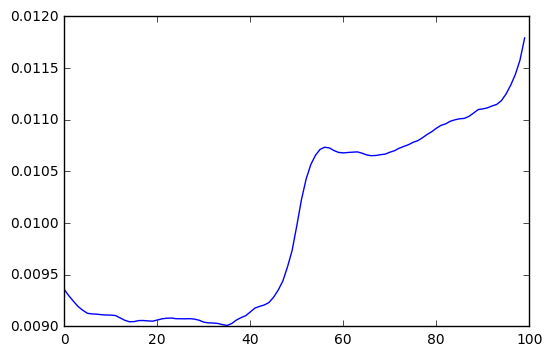

In [56]:
plt.plot(calculate_pdf(dx).mean())

# PDF of input density

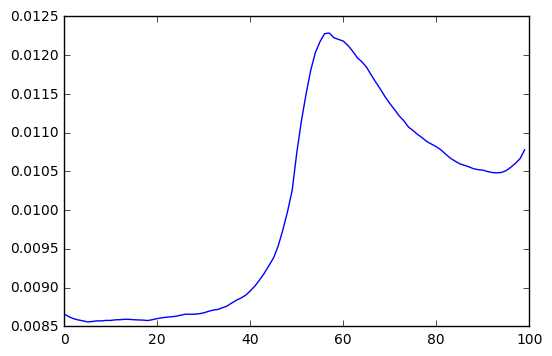

In [57]:
plt.plot(calculate_pdf(dxi).mean())

# Subtraction normalization gives weird dip.

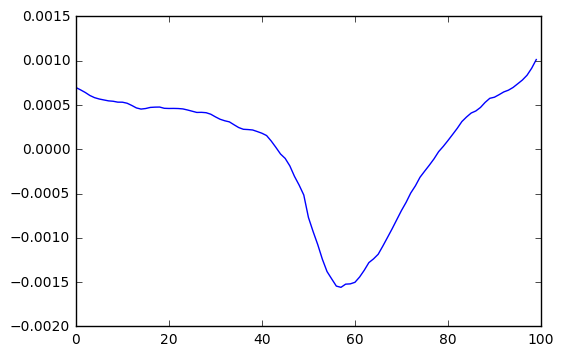

In [58]:
sub = normalize_and_per_region_subtract(dx, dxi)
plt.plot(sub.mean())